In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statistics as st

from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Import and read the dataset
df = pd.read_csv("3A.tsv", sep = "\t")
df.head()

,index,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,-92.0,NaN,NaN


## A. EDA

In [3]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16928 non-null  int64  
 1   Name             16926 non-null  object 
 2   Platform         16928 non-null  object 
 3   Year_of_Release  16928 non-null  int64  
 4   Genre            16926 non-null  object 
 5   Publisher        16873 non-null  object 
 6   NA_Sales         16928 non-null  float64
 7   EU_Sales         16928 non-null  float64
 8   JP_Sales         16928 non-null  float64
 9   Other_Sales      16928 non-null  float64
 10  Global_Sales     16928 non-null  float64
 11  Critic_Score     8260 non-null   float64
 12  Critic_Count     8260 non-null   float64
 13  User_Score       10159 non-null  object 
 14  User_Count       16928 non-null  float64
 15  Developer        10240 non-null  object 
 16  Rating           10092 non-null  object 
dtypes: float64(8

In [4]:
# Drop column index
print('Count of unique value in column ID:', len(pd.unique(df['index'])))
df = df.drop('index', axis=1)
df.head(3)

Count of unique value in column ID: 16928


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E


Column index is an identifier (unique) so it does not give useful information to the model

In [5]:
# Convert the negative value of User_Count (which impossible) to null value
print((df['User_Count'] < 0).sum())
df['User_Count'] = df['User_Count'].apply(lambda x: x if x >= 0 else np.nan)

9210


User_Count is the number of users playing the game, so it should be 0 or positive.

In [6]:
# Check 'tbd' value in User_Score
print(df['User_Score'].unique())
df['User_Score'] = df['User_Score'].apply(lambda x: np.nan if x == 'tbd' else x)

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


There is 'tbd' in User_Score. It is an anomaly, so 'tbd' is considered as null value.

In [7]:
# Check the value of Year_of_Release
print(df['Year_of_Release'].value_counts())

df['Year_of_Release'] = df['Year_of_Release'].apply(lambda x: np.nan if x < 1900 else x)

# Fill NaN values with the mode
mode_value = df['Year_of_Release'].mode()[0]
df['Year_of_Release'] = df['Year_of_Release'].fillna(mode_value).astype(int)

print(df['Year_of_Release'].value_counts())

Year_of_Release
2009    1448
2008    1441
2010    1269
2007    1209
2011    1150
2006    1014
2005     949
2002     841
2003     784
2004     773
2012     662
2015     612
2014     595
2013     549
2016     507
2001     490
1998     386
2000     354
1999     343
1997     293
1996     267
1995     222
1994     121
1993      63
1981      46
1992      43
1991      42
1982      39
8         32
3         31
7         30
10        30
6         30
2         29
5         27
1         24
4         23
1986      21
1989      17
1983      17
9         17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
2017       3
2020       1
Name: count, dtype: int64
Year_of_Release
2009    1721
2008    1441
2010    1269
2007    1209
2011    1150
2006    1014
2005     949
2002     841
2003     784
2004     773
2012     662
2015     612
2014     595
2013     549
2016     507
2001     490
1998     386
2000     354
1999     343
1997     293
1996     267
1995     222
1994     121
1993  

There are values of 1 until 10, which considered as null values. It is an anomaly in "year" context. While Year_of_Release is numerical, it represents a categorical-like feature because each year is distinct and not continuous. So, the null values are imputed using mode. 

In [8]:
# Check missing values
print(df.shape)
print(df.isna().sum())

(16928, 16)
Name                  2
Platform              0
Year_of_Release       0
Genre                 2
Publisher            55
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8668
Critic_Count       8668
User_Score         9210
User_Count         9210
Developer          6688
Rating             6836
dtype: int64


In [9]:
# Impute Categorical Data with Mode
print("Mode of Publisher:", st.mode(df['Publisher']))
df['Publisher'].fillna(st.mode(df['Publisher']), inplace=True)

df.isna().sum()

Mode of Publisher: Electronic Arts


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22052\3742503120.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Publisher'].fillna(st.mode(df['Publisher']), inplace=True)


Name                  2
Platform              0
Year_of_Release       0
Genre                 2
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8668
Critic_Count       8668
User_Score         9210
User_Count         9210
Developer          6688
Rating             6836
dtype: int64

The number of missing values in Publisher are very small (55 from 16928), so it is imputed using mode.

In [10]:
# Drop columns
df.drop(['Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'], axis=1, inplace=True)

print(df.shape)
print(df.isna().sum())

(16928, 11)
Name                  2
Platform              0
Year_of_Release       0
Genre                 2
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Developer          6688
Rating             6836
dtype: int64


- Global_Sales is the sum of the other sales, it does not add unique information to the dataset. Retaining it may lead to redundancy and potential multicollinearity in models.
- Column Critic_Score (8668 from 16928), Critic_Count (8668 from 16928), User_Score (9210 from 16928), User_Count (9210 from 16928) are dropped because the number of missing values are more than 50%. Those columns also does not have much impact on content based filtering.

In [11]:
# Drop missing values by rows
df = df.dropna(subset=['Name', 'Genre']).reset_index(drop=True)

print(df.shape)
print(df.isna().sum())

(16926, 11)
Name                  0
Platform              0
Year_of_Release       0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Developer          6686
Rating             6834
dtype: int64


Missing values in Name and Genre are dropped because the number of missing values are really small. 

In [12]:
# Impute missing values with "Unknown" for 'Developer' and 'Rating'
df['Developer'] = df['Developer'].fillna('Unknown')
df['Rating'] = df['Rating'].fillna('Unknown')

print(df.shape)
print(df.isna().sum())

(16926, 11)
Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Developer          0
Rating             0
dtype: int64


Developer has 6686 missing values and Rating has 6834 missing values. Dropping these rows would discard half of the dataset, significantly reducing the size of data and potentially missing important games. A smaller dataset limits the diversity of recommendations. So, the missing values in Developer and Rating will be imputed using "Unknown".

In [13]:
# Check duplicate rows
print(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

print(df.shape)

209
(16717, 11)


There is 209 duplicated rows and already dropped.

In [14]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16717.000000,16717.000000,16717.000000,16717.000000,16717.000000
mean,2006.529401,0.263255,0.145010,0.077610,0.047333
std,5.838543,0.813475,0.503303,0.308836,0.186721
min,1980.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,0.080000,0.020000,0.000000,0.010000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000
max,2020.000000,41.360000,28.960000,10.220000,10.570000


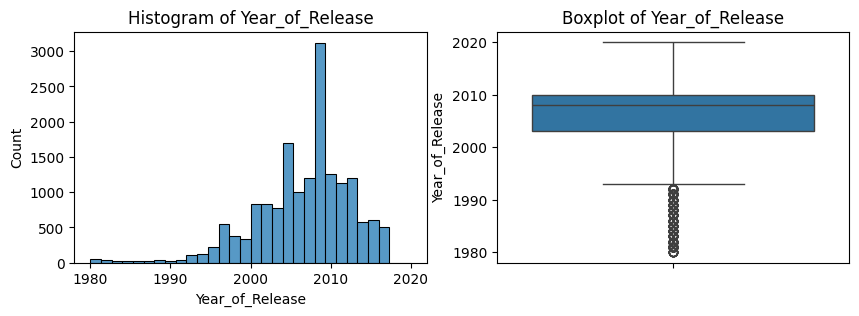

Skewness of Year_of_Release: -0.9964965291102612
Kurtosis of Year_of_Release: 1.8520899942837867


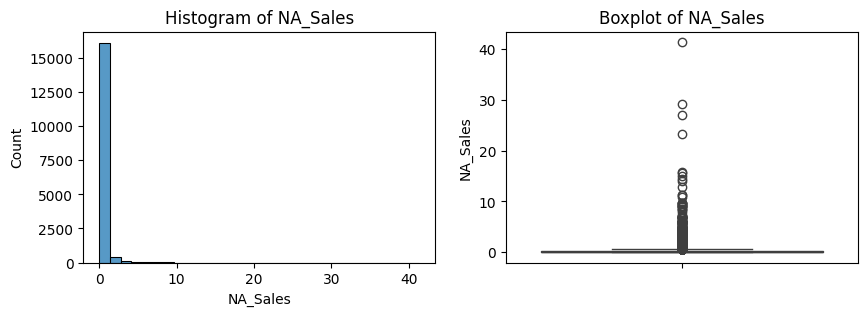

Skewness of NA_Sales: 18.77859115366832
Kurtosis of NA_Sales: 648.9086970873321


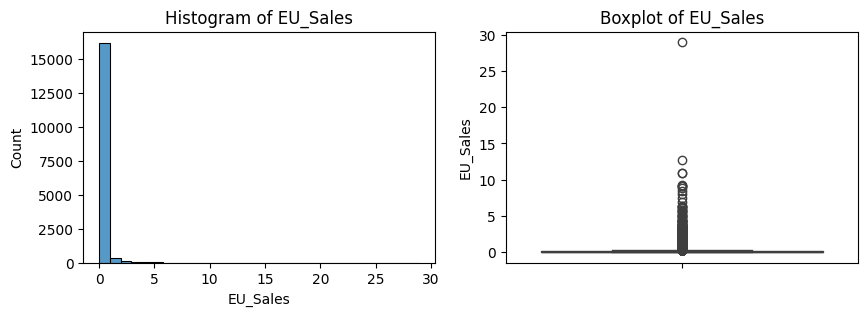

Skewness of EU_Sales: 18.853002034345685
Kurtosis of EU_Sales: 755.6449821906995


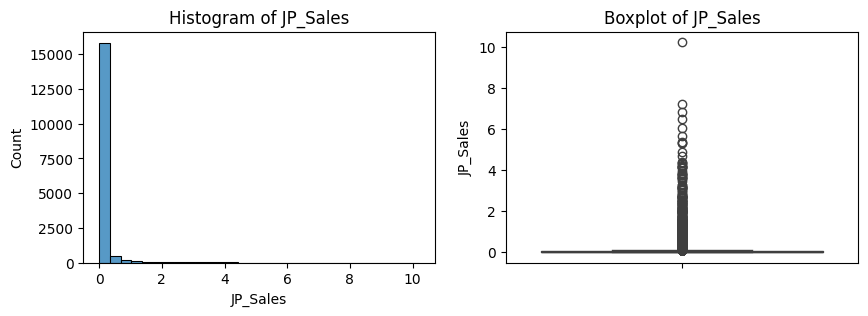

Skewness of JP_Sales: 11.208114618801341
Kurtosis of JP_Sales: 194.28891551844995


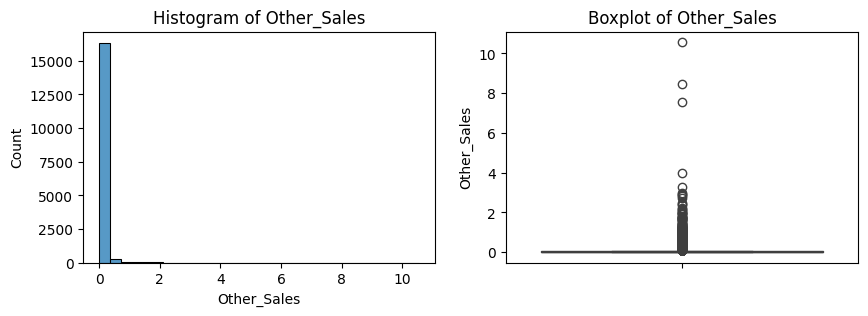

Skewness of Other_Sales: 24.585008130420814
Kurtosis of Other_Sales: 1055.0127092287055


In [15]:
# Check the distribution and outliers of numerical columns
num_cols = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

def check_distribution(df, columns):
    for i in columns:
        plt.figure(figsize=(10,3))

        # histogram
        plt.subplot(1,2,1)
        sns.histplot(df[i], bins=30)
        plt.title(f'Histogram of {i}')

        # boxplot
        plt.subplot(1,2,2)
        sns.boxplot(y=df[i], data=df)
        plt.title(f'Boxplot of {i}')

        plt.show()

        print(f'Skewness of {i}:', df[i].skew())
        print(f'Kurtosis of {i}:', df[i].kurt())

check_distribution(df[num_cols], num_cols)

There is outliers in all numerical values and the distributed is very skewed. Hence, the scaling uses Robust Scaler

In [16]:
# Perform Robust Scaler
rob_scaler = RobustScaler()
df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = rob_scaler.fit_transform(df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']])

In [17]:
# Check the unique values and the count of it from categorical columns
cat_cols = ['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'Developer', 'Rating']
for i in cat_cols:
    print(df[i].value_counts(), "\n")

Name
Need for Speed: Most Wanted                                                       12
Ratatouille                                                                        9
Madden NFL 07                                                                      9
LEGO Marvel Super Heroes                                                           9
FIFA 14                                                                            9
                                                                                  ..
Mahou Sensei Negima!? Neo-Pactio Fight!!                                           1
Sweet Honey Coming                                                                 1
Psychic Detective                                                                  1
Hanasaku Manimani                                                                  1
Fujiko F. Fujio Characters: Great Assembly! Slightly Fantastic Slapstick Party     1
Name: count, Length: 11562, dtype: int64 

Platform
PS2     

In [18]:
# Convert numerical columns to strings
df['Year_of_Release'] = df['Year_of_Release'].astype(str)
df['NA_Sales'] = df['NA_Sales'].astype(str)
df['EU_Sales'] = df['EU_Sales'].astype(str)
df['JP_Sales'] = df['JP_Sales'].astype(str)
df['Other_Sales'] = df['Other_Sales'].astype(str)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16717 entries, 0 to 16716
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             16717 non-null  object
 1   Platform         16717 non-null  object
 2   Year_of_Release  16717 non-null  object
 3   Genre            16717 non-null  object
 4   Publisher        16717 non-null  object
 5   NA_Sales         16717 non-null  object
 6   EU_Sales         16717 non-null  object
 7   JP_Sales         16717 non-null  object
 8   Other_Sales      16717 non-null  object
 9   Developer        16717 non-null  object
 10  Rating           16717 non-null  object
dtypes: object(11)
memory usage: 1.4+ MB


In [20]:
df = df.reset_index(drop=True)
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,172.0,263.0909090909091,94.25,281.3333333333333,Nintendo,E
1,Super Mario Bros.,NES,1985,Platform,Nintendo,120.83333333333334,32.36363636363637,170.25,25.333333333333336,Unknown,Unknown
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,65.0,115.81818181818181,94.75,109.33333333333334,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,64.70833333333333,99.18181818181819,82.0,98.00000000000001,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,46.625,80.63636363636364,255.5,33.0,Unknown,Unknown


### Summary of EDA
- There is 16928 rows of data and 17 columns, with 1 identifier column that then dropped.
- There are negative values in User_Count, so it converted to null values.
- There are 'tbd' value in User_Score, so it converted to null values.
- There are value 1-10 in Year_of_Release and converted to null values and then it imputed using mode.
- The missing values in Publisher are very small, so it is imputed using mode. 
- The column Global_Sales is dropped because it is the sum of the other sales that does not add unique information to the dataset. Retaining it may lead to redundancy and potential multicollinearity in models. 
- Column Critic_Score, Critic_Count , User_Score , User_Count are dropped because those columns also does not have much impact on content based filtering. Besides that, the number of missing values are more than 50%. 
- Missing values in Name and Genre are dropped because the number of missing values are really small. 
- Missing values in Developer and Rating are imputed using "Unknown" because dropping can limit the diversity of recommendation. 
- There are 209 duplicated rows and dropped.
- The remaining data is 16717 rows of data with 11 columns.
- There are outliers in numerical variables.
- There are some game name that has same values (not unique).
- All variables are converted to string type for TF-IDF vectorization

## B. Content-Based Recommender System

In [21]:
# Combine relevant columns for TF-IDF vectorization
df['combined_features'] = df['Name'] + " " + df['Genre'] + " " + df['Platform'] + " " + df['Publisher'] + " " + df['Year_of_Release'] + " " + df['Developer'] + " " + df['Rating'] + " " + df['NA_Sales'] + " " +df['EU_Sales'] + " " + df['JP_Sales'] + " " + df['Other_Sales']

# Create the TF-IDF matrix using the combined features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [22]:
# Recommendation function
def get_recommendations(title, cosine_sim=cosine_sim, num_recommend=10):
    # Check if the title exists in the dataset
    if title not in df['Name'].values:
        return f"Game title '{title}' not found in the dataset."
    
    # Check if the title is unique or has duplicates
    if df['Name'].value_counts()[title] == 1:
        # Case for unique title
        indices = pd.Series(df.index, index=df['Name']).drop_duplicates()
        idx = indices[title]
        
        # Get pairwise similarity scores for the game
        sim_scores = list(enumerate(cosine_sim[idx]))
        
        # Sort the games by similarity score
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Get the top similar games (excluding the input game)
        top_similar = sim_scores[1:num_recommend+1]
        
        # Extract the game indices of the top similar games
        game_indices = [i[0] for i in top_similar]
    
    else:
        # Case for duplicate title
        # Find all indices corresponding to the title (to handle duplicates)
        indices = pd.Series(df.index, index=df['Name'])
        matching_indices = indices[title].tolist()  # List of all indices for the same title

        # Initialize the list of similarity scores
        sim_scores = []

        # If there are duplicates, aggregate similarity scores for all matching indices
        for idx in matching_indices:
            sim_scores.extend(list(enumerate(cosine_sim[idx])))

        # Sort all similarity scores by similarity value
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Filter out recommendations that have the same name as the input title
        sim_scores = [score for score in sim_scores if df['Name'].iloc[score[0]] != title]

        # Get the top similar games (excluding the game itself)
        top_similar = sim_scores[:num_recommend]
        
        # Extract the game indices of the top similar games
        game_indices = [i[0] for i in top_similar]
    
    # Return the names of the recommended games with their similarity scores
    ret_df = df.iloc[game_indices].copy()
    ret_df['Score'] = np.array(top_similar)[:, 1]  # Add similarity score column

    # Drop the 'combined_features' column
    ret_df = ret_df.drop(columns=['combined_features'])
    
    # Reorder columns to put 'score' next to 'Name'
    columns = ['Name', 'Score'] + [col for col in ret_df.columns if col not in ['Name', 'Score', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
    ret_df = ret_df[columns]

    return ret_df

In [23]:
# Get the recommendation
get_recommendations("LEGO Jurassic World", num_recommend=5)

,Name,Score,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
13304,LEGO The Hobbit,0.650770,PC,2014,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
12455,The LEGO Movie Videogame,0.622130,PC,2014,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
12440,Lego Batman 3: Beyond Gotham,0.614076,PC,2014,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
2334,Lego Batman 3: Beyond Gotham,0.611245,X360,2014,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
3010,The LEGO Movie Videogame,0.603086,PS4,2014,Action,Warner Bros. Interactive Entertainment,TT Games,E10+


In [32]:
df[df['Name'] == 'LEGO Jurassic World'].drop(columns=['combined_features', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

,Name,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
2300,LEGO Jurassic World,PS4,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
2401,LEGO Jurassic World,X360,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
2434,LEGO Jurassic World,PS3,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
3083,LEGO Jurassic World,XOne,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
3229,LEGO Jurassic World,3DS,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
3839,LEGO Jurassic World,WiiU,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
7124,LEGO Jurassic World,PSV,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+
13941,LEGO Jurassic World,PC,2015,Action,Warner Bros. Interactive Entertainment,TT Games,E10+


## C. Evaluation

### First Input

In [36]:
get_recommendations("Pokemon Red/Pokemon Blue", num_recommend=5)

,Name,Score,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
819,Pokemon Mystery Dungeon: Red/Blue Rescue Team,0.400725,GBA,2005,Role-Playing,Nintendo,Unknown,Unknown
27,Pokemon Black/Pokemon White,0.373480,DS,2010,Role-Playing,Nintendo,Unknown,Unknown
12,Pokemon Gold/Pokemon Silver,0.352177,GB,1999,Role-Playing,Nintendo,Unknown,Unknown
11059,Pokemon Rumble World,0.337625,3DS,2015,Action,Nintendo,"Ambrella, The Pokemon Company",E10+
83,Pokemon Black 2/Pokemon White 2,0.334961,DS,2012,Role-Playing,Nintendo,Unknown,Unknown


In [37]:
df[df['Name'] == 'Pokemon Red/Pokemon Blue'].drop(columns=['combined_features', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

,Name,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,Unknown,Unknown


Similarity Analysis:
1. Pokemon Mystery Dungeon: Red/Blue Rescue Team: The strong similarity likely stems from the shared genre (Role-Playing) and publisher (Nintendo). It also has thematic connection as both games are part of the Pokemon universe.
2. Pokemon Black/Pokemon White: It matches genre (Role-Playing), publisher (Nintendo), and thematic connection as both games are part of the Pokemon universe.
3. Pokemon Gold/Pokemon Silver: It matches genre (Role-Playing), platform (GB), publisher (Nintendo), and thematic connection as both games are part of the Pokemon universe.
4. Pokemon Rumble World: It matches publisher (Nintendo) and thematic connection as both games are part of the Pokemon universe.
5. Pokemon Black 2/Pokemon White 2: It matches genre (Role-Playing), publisher (Nintendo), and thematic connection as both games are part of the Pokemon universe.

- The function prioritizes games within the same Name, as all recommendations are "Pokemon" titles.
- High relevance to the input genre (Role-Playing) and publisher (Nintendo)

### Second Input

In [150]:
get_recommendations("Final Fantasy IX", num_recommend=5)

,Name,Score,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
8224,Final Fantasy V,0.577982,PS,1998,Role-Playing,SquareSoft,Unknown,Unknown
627,Final Fantasy Tactics,0.506021,PS,1997,Role-Playing,SquareSoft,SquareSoft,T
88,Final Fantasy VIII,0.493658,PS,1999,Role-Playing,SquareSoft,SquareSoft,T
3868,Final Fantasy,0.480081,WS,2000,Role-Playing,SquareSoft,Unknown,Unknown
4937,Final Fantasy Adventure,0.462182,GB,1991,Role-Playing,SquareSoft,Unknown,Unknown


In [33]:
df[df['Name'] == 'Final Fantasy IX'].drop(columns=['combined_features', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

,Name,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
175,Final Fantasy IX,PS,2000,Role-Playing,SquareSoft,SquareSoft,T


Similarity Analysis:
1. Final Fantasy V: It matches the platform (PS), genre (Role-Playing), and publisher (SquareSoft). 
2. Final Fantasy Tactics: It matches platform (PS), genre (Role-Playing), publisher (SquareSoft), developer (SquareSoft), and rating (T). 
3. Final Fantasy VIII: It matches platform (PS), genre (Role-Playing), publisher (SquareSoft), developer (SquareSoft), and rating (T). 
4. Final Fantasy: It matches with genre (Role-Playing), year (2000) publisher (SquareSoft). 
5. Final Fantasy Adventure: It matches with genre (Role-Playing) and publisher (SquareSoft).

- The function prioritizes games within the same Name, as all recommendations are "Final Fantasy" titles.
- High relevance to the input platform (PS) and genre (Role-Playing).
- Publisher and developer (SquareSoft) are well-matched.

### Third Input

In [29]:
get_recommendations("Mario Kart Wii", num_recommend=5)

,Name,Score,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
13,Wii Fit,0.369145,Wii,2007,Sports,Nintendo,Nintendo,E
7,Wii Play,0.342590,Wii,2006,Misc,Nintendo,Nintendo,E
110,Mario Kart 8,0.275425,WiiU,2014,Racing,Nintendo,Nintendo,E
418,Wii Music,0.252445,Wii,2008,Misc,Nintendo,Nintendo,E
0,Wii Sports,0.250230,Wii,2006,Sports,Nintendo,Nintendo,E


In [34]:
df[df['Name'] == 'Mario Kart Wii'].drop(columns=['combined_features', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

,Name,Platform,Year_of_Release,Genre,Publisher,Developer,Rating
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,Nintendo,E


Similarity Analysis:
1. Wii Fit: It matches the platform (Wii), publisher (Nintendo), developer (Nintendo), and rating (E). 
2. Wii Play: It matches platform (Wii), publisher (Nintendo), developer (Nintendo), and rating (E). 
3. Mario Kart 8: It matches genre (Racing), publisher (Nintendo), developer (Nintendo), and rating (E). 
4. Wii Music: It matches with platform (Wii), publisher (Nintendo), developer (Nintendo), and rating (E). 
5. Wii Sports: It matches with platform (Wii), year (2008), publisher (Nintendo), developer (Nintendo), and rating (E)


- Most recommended games are from the same platform (Wii).
- All recommendations share the same publisher and developer (Nintendo), also rating (E).